In [565]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error

df_basinc = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/basinc.csv')
df_bulut = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/bulut.csv')
df_nem = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/nem.csv')
df_ruzgar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/ruzgar.csv')
df_sicaklik = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/sicaklik.csv')
df_yagmur = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/yagmur.csv')
df_kar = pd.read_csv('/Users/ardahanaytan/Desktop/STAJ/Hava Durumu Tahmin Projesi/data/weather_datas/kar.csv')

tables = [df_nem, df_ruzgar, df_sicaklik, df_yagmur, df_kar]
df = pd.merge(df_basinc, df_bulut, on=['Zaman'])
for i in tables:
    df = pd.merge(df, i, on=['Zaman'])

df['Yil'] = df['Zaman'].str[:4].astype(int)
df['Ay'] = df['Zaman'].str[4:6].astype(int)
df['Gun'] = df['Zaman'].str[6:8].astype(int)
df['Saat'] = df['Zaman'].str[9:].str[:2].astype(int)
df['datetime'] = pd.to_datetime(df[['Yil', 'Ay', 'Gun']].astype(str).agg('-'.join, axis=1) + ' ' + 
                                df['Saat'].astype(str), format='%Y-%m-%d %H')
df.set_index('datetime', inplace=True)
df.drop(columns=['Zaman', 'Yil', 'Ay', 'Gun', 'Saat'], inplace=True)

df.head()

,Basinc,Bulut,Nem,Ruzgar_Hizi,Ruzgar_Yonu,Sicaklik,Yagmur,Kar
datetime,,,,,,,,
1994-01-01 00:00:00,1006.0,97.0,91.332990,9.339208,207.55281,6.840245,0.6,0.0
1994-01-01 01:00:00,1005.1,99.0,90.645615,6.489992,213.69006,6.980245,1.1,0.0
1994-01-01 02:00:00,1005.3,100.0,92.565414,7.235910,264.28943,6.110245,2.2,0.0
1994-01-01 03:00:00,1006.0,100.0,96.283560,13.684735,296.56506,4.990245,2.3,0.0
1994-01-01 04:00:00,1008.5,100.0,92.844430,17.227420,296.02960,4.500246,1.2,0.0


In [641]:
df_t = pd.DataFrame({'Sicaklik': df['Sicaklik']})
train_df = df_t[:'2020'].resample('M').mean()
test_df = df_t['2021':].resample('M').mean()

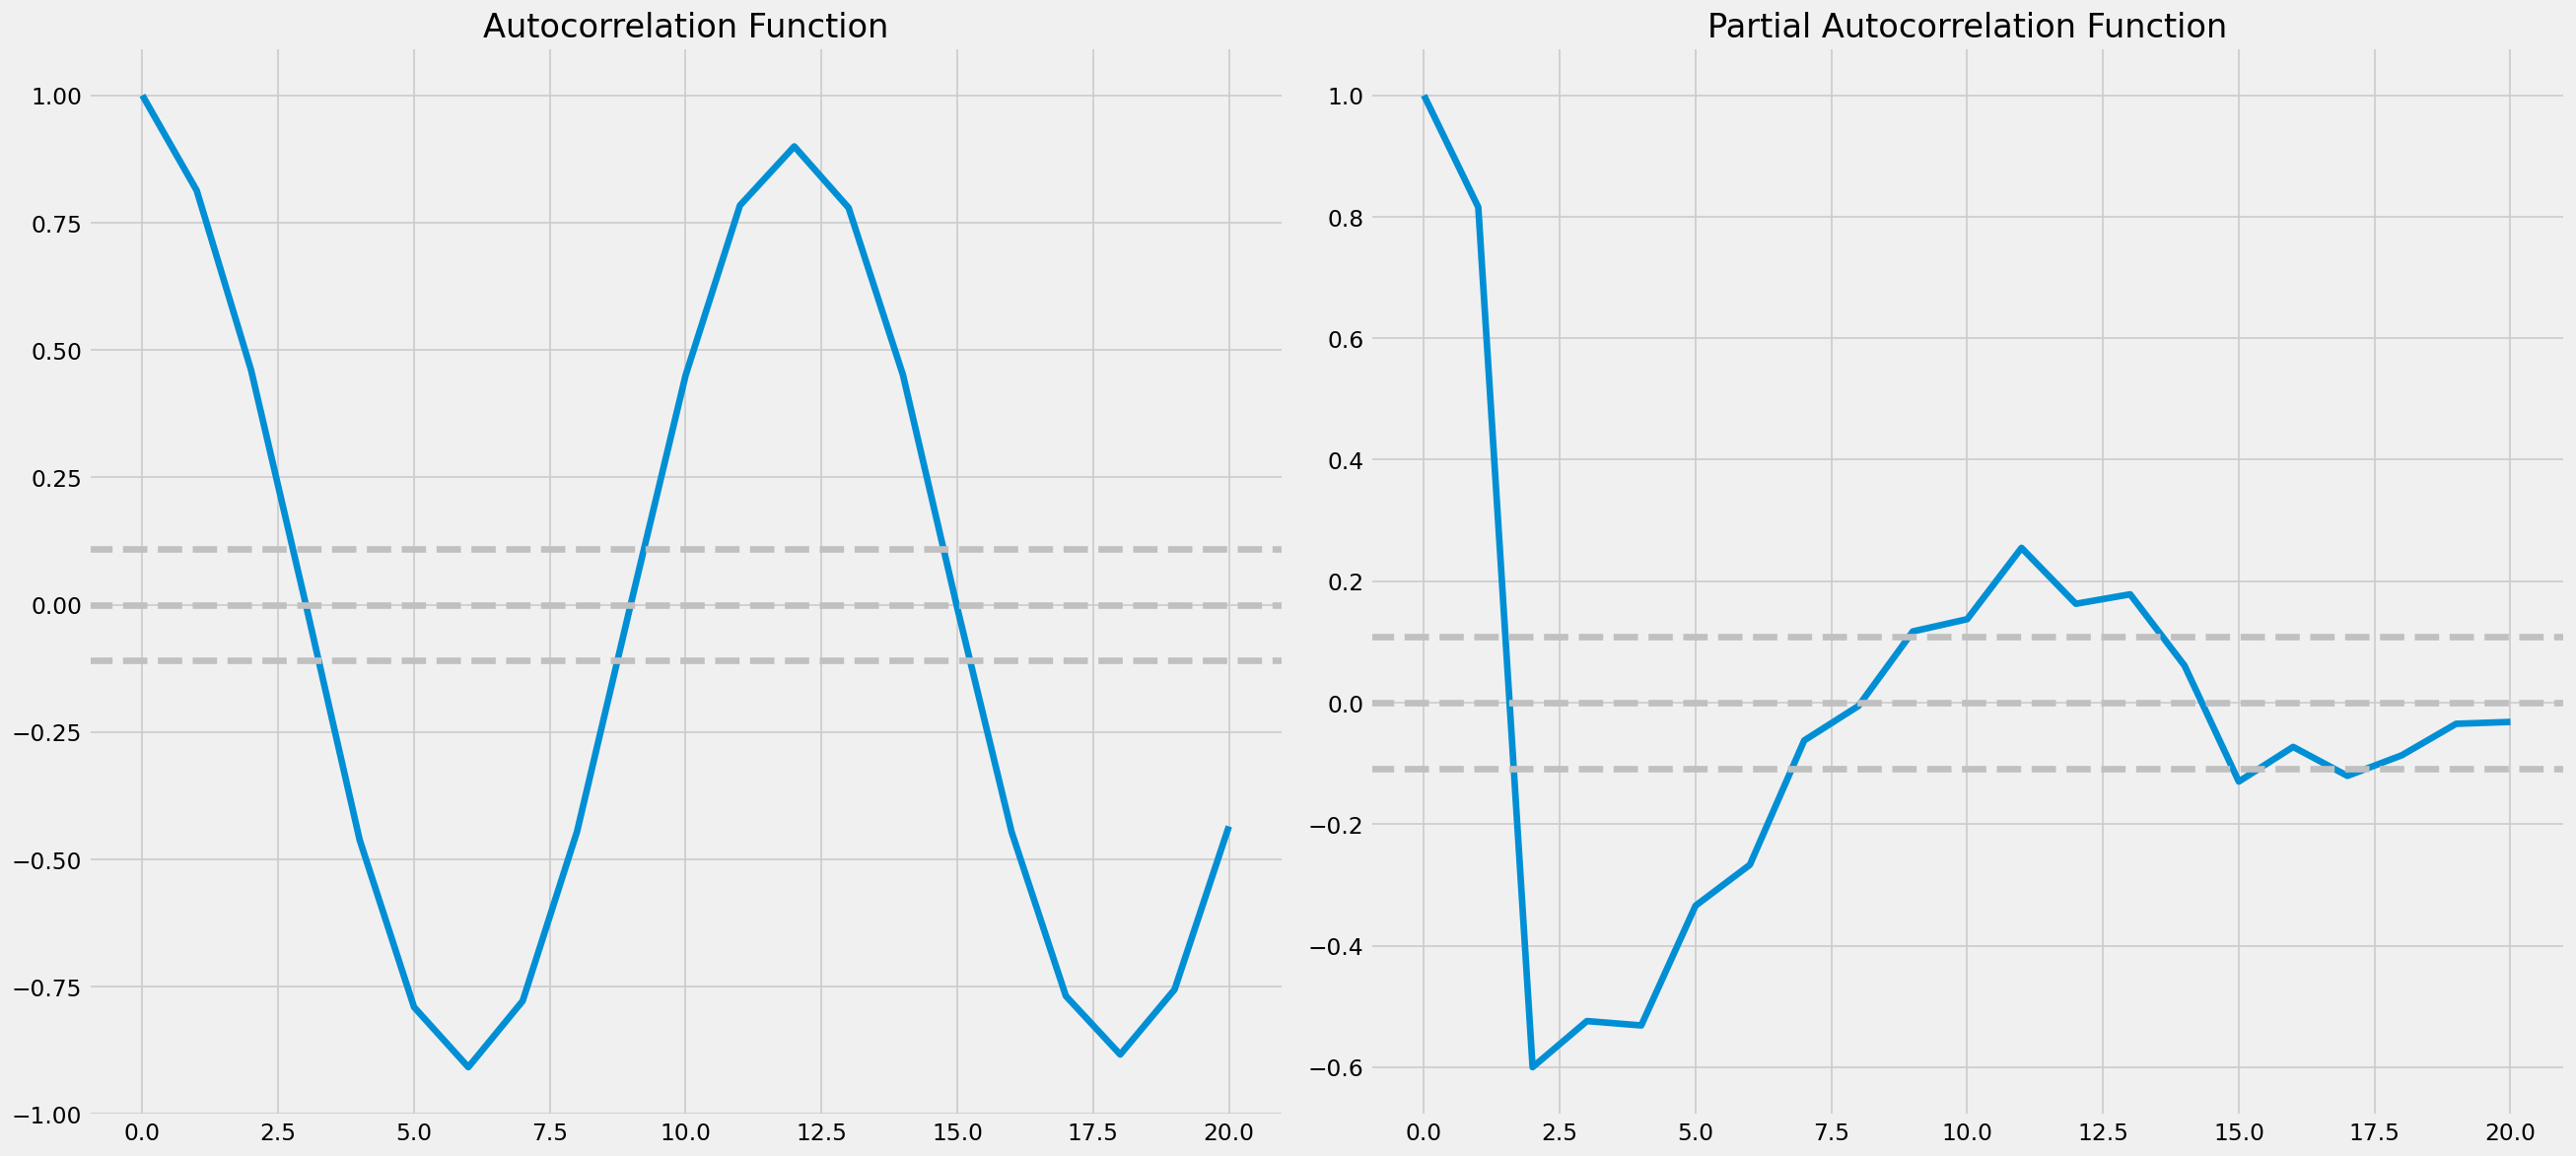

In [642]:
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [643]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  324
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -651.670
Date:                Mon, 02 Sep 2024   AIC                           1315.340
Time:                        16:24:15   BIC                           1338.025
Sample:                             0   HQIC                          1324.394
                                - 324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1625      0.103    108.582      0.000      10.961      11.364
ar.L1          1.7320      0.000   7668.064      0.000       1.732       1.732
ar.L2         -1.0000   5.26e-05   -1.9e+04      0.0

/Users/ardahanaytan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


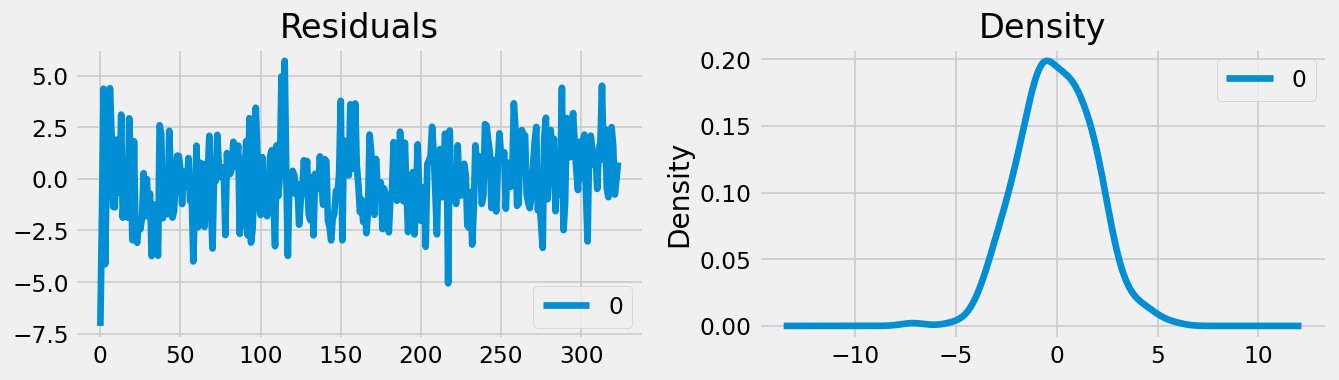

In [644]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

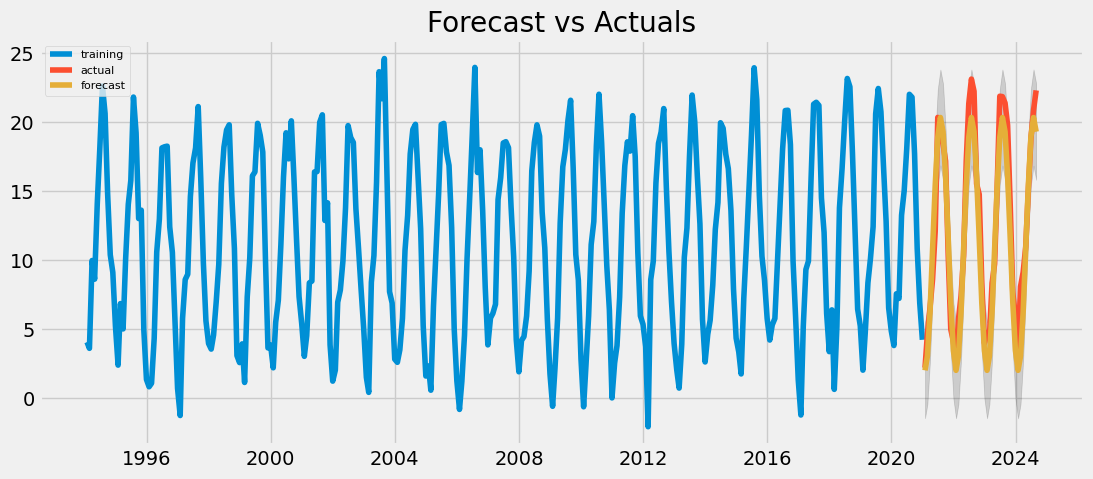

In [645]:
#fc, se, conf = model_fit.forecast(16, alpha=0.05)
forecast_obj = model_fit.get_forecast(steps=44)

fc = forecast_obj.predicted_mean
se = forecast_obj.se_mean
conf = forecast_obj.conf_int(alpha=0.05)

fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

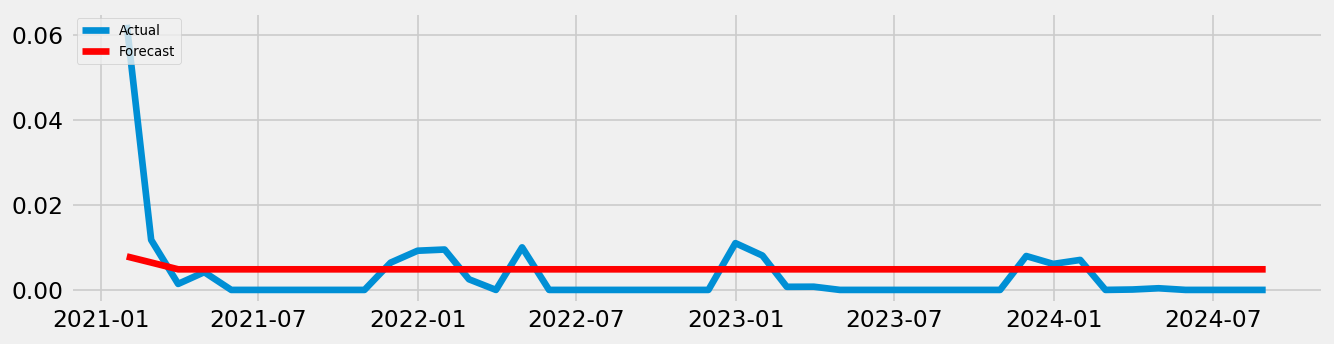

In [639]:
plt.plot(test_df, label='Actual')
plt.plot(fc_series, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [640]:
error = mean_squared_error(test_df, fc_series)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  8.723588636667824e-05
